# **Solving a Sudoku problem**

***sudoku.ipynb***

Sudoku: place numbers from 1 to 9 into a 9x9 grid such that no number repeats in any row, in any column, and in any 3x3 sub-grid. 

&copy; Copyright 2025 Fair Isaac Corporation

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.
 
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This example uses FICO&reg; Xpress software. By running it, you agree to the Community License terms of the [Xpress Shrinkwrap License Agreement](https://community.fico.com/s/contentdocument/06980000002h0i5AAA) with respect to the FICO&reg; Xpress software. See the [licensing options](https://www.fico.com/en/fico-xpress-trial-and-licensing-options) overview for additional details and information about obtaining a paid license.

In [ ]:
# Install the xpress package
%pip install -q xpress

## Problem description and formulation



In classic sudoku, the objective is to fill a $n \times n$ grid with digits so that each column, each row, and each of the nine $q \times q$ subgrids that compose the grid (also called "boxes", "blocks", or "regions") contains all of the digits from 1 to $n$. The puzzle setter provides a partially completed grid, which for a well-posed puzzle has a single solution.

Several formulations exist for this problem, where choosing the right variables is a fundamental step. Although all cells must contain integer numbers, using integer decision variables would make it hard to guarantee that they are different within a given block (row/column) with a mathematical programming formulation. Alternatively, a Constraint Programming formulation can be applied, as shown in the blog post [Solving Sudoku: A Constraint Programming Play](https://community.fico.com/s/blog-post/a5Q4W000001V7gdUAC/fico2486).

In this example, we use binary variables $assign_{i,j,k}$ that indicate whether a value $k \in \{1,..,9\}$ is assigned to a given cell $i,j \in \mathcal{N}$ of the grid (=1) or not (=0). Also, no objective function is needed: this is a __feasibility__ problem not an __optimization__ problem, subject to the following constraints:

$$
\begin{align*}
& \hbox{Each cell can only have one value:} \\
& \qquad \sum_{k \in \mathcal{N}} assign_{i,j,k} = 1, \qquad \forall i,j \in \mathcal{N} \\
& \hbox{Assign values already in grid ($g_{i,j}$ has a positive value):} \\
& \qquad assign_{i,j,k} = 1, \qquad \forall i,j \in \mathcal{N}, k = g_{i,j},  g_{i,j} > 0\\
& \hbox{Every number must appear once on every row:} \\
& \qquad \sum_{j \in \mathcal{N}} assign_{i,j,k} = 1, \qquad \forall i,k \in \mathcal{N} \\
& \hbox{Every number must appear once on every column:} \\
& \qquad \sum_{i \in \mathcal{N}} assign_{i,j,k} = 1, \qquad \forall j,k \in \mathcal{N} \\
& \hbox{Every number must appear once in every $q \times q$ block:} \\
& \qquad \sum_{i,j \in \mathcal{Q}: n = i+q.h, m = j+q.l} assign_{n,m,k} = 1, \qquad \forall h,l \in \mathcal{Q}, \forall k \in \mathcal{N} \\

\end{align*}
$$

where $\mathcal{N}=\{1,..,9\}$ and $\mathcal{Q}=\{1,..,3\}$.

## Data preparation

The input is a starting grid where the unknown numbers are replaced by zero. We start with a $9 \times 9$ grid, and provide a $16 \times 16$ option at the bottom of this notebook. 

|   |   |   |   |   |   |   |   |   |
|---|---|---|---|---|---|---|---|---|
| 8 |   |   |   |   |   |   |   |   |
|   |   | 3 | 6 |   |   |   |   |   |
|   | 7 |   |   | 9 |   | 2 |   |   |
|   | 5 |   |   |   | 7 |   |   |   |
|   |   |   |   | 4 | 5 | 7 |   |   |
|   |   |   | 1 |   |   |   | 3 |   |
|   |   | 1 |   |   |   |   | 6 | 8 |
|   |   | 8 | 5 |   |   |   | 1 |   |
|   | 9 |   |   |   |   | 4 |   |   |

In [1]:
import xpress as xp
import numpy as np
import matplotlib.pyplot as plt
import math

# Initial data for the sudoku solver
grid3x3 = \
 [[8, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 3, 6, 0, 0, 0, 0, 0],
  [0, 7, 0, 0, 9, 0, 2, 0, 0],
  [0, 5, 0, 0, 0, 7, 0, 0, 0],
  [0, 0, 0, 0, 4, 5, 7, 0, 0],
  [0, 0, 0, 1, 0, 0, 0, 3, 0],
  [0, 0, 1, 0, 0, 0, 0, 6, 8],
  [0, 0, 8, 5, 0, 0, 0, 1, 0],
  [0, 9, 0, 0, 0, 0, 4, 0, 0]]

grid = grid3x3
q = 3

## Model implementation and results

When passing sets, lists, or range objects to [prob.addVariables()](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.addVariables.html), the result is a Python dictionary of variables, whose keys are tuples of indices. Variables $x$ are created this way.

The constraints are then created and added to the problem directly by passing the corresponding expression as a list comprehension. Note that no objective is set as this is a feasibility problem.

In [2]:
# Main dimensions of the problem: q is the size of the qxq block (3x3 in the classic Sudoku game).

n = q**2       # the size must be the square of the size of the subgrids
N = range(n)   # set of numbers from 0 to n-1
Q = range(q)   # set of numbers from 0 to q-1

# Create a model
prob = xp.problem()

assign = prob.addVariables(N, N, N, vartype=xp.binary)

# Constraint 1: each cell can only have one value
prob.addConstraint(xp.Sum(assign[i,j,k] for k in N) == 1 for i in N for j in N)

# Constraint 2: fix the cells in the starting grid
prob.addConstraint(assign[i,j,grid[i][j] - 1] == 1 for i in N for j in N if grid[i][j] > 0)

# Constraint 3a: Every number must appear once on every row
prob.addConstraint(xp.Sum(assign[i,j,k] for j in N) == 1 for i in N for k in N)

# Constraint 3b: ... and on every column
prob.addConstraint(xp.Sum(assign[i,j,k] for i in N) == 1 for j in N for k in N)

# Constraint 3c: Every number must appear once in every qxq block
prob.addConstraint(xp.Sum(assign[i+q*h,j+q*l,k] for i in Q for j in Q) == 1 for h in Q for l in Q for k in N)

prob.optimize()

FICO Xpress v9.5.3, Hyper, solve started 11:33:19, Feb 19, 2025
Heap usage: 669KB (peak 669KB, 213KB system)
Minimizing MILP noname using up to 20 threads and up to 31GB memory, with these control settings:
OUTPUTLOG = 1
NLPPOSTSOLVE = 1
XSLP_DELETIONCONTROL = 0
XSLP_OBJSENSE = 1
Original problem has:
       345 rows          729 cols         2937 elements       729 entities
Presolved problem has:
       139 rows          197 cols          580 elements       197 entities
LP relaxation tightened
Presolve finished in 0 seconds
Heap usage: 920KB (peak 1392KB, 213KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  1.00e+00] / [ 1.00e+00,  1.00e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  1.00e+00] / [ 1.00e+00,  1.00e+00]
  Objective      [min,max] : [      0.0,       0.0] / [      0.0,       0.0]
Autoscaling applied standard scaling

Will try to keep branch and bound tree memory usage below 23.2GB
Starting co

(<SolveStatus.COMPLETED: 3>, <SolStatus.OPTIMAL: 1>)

Now we use *matplotlib* to visualize the solution in a $n\times n$ grid.

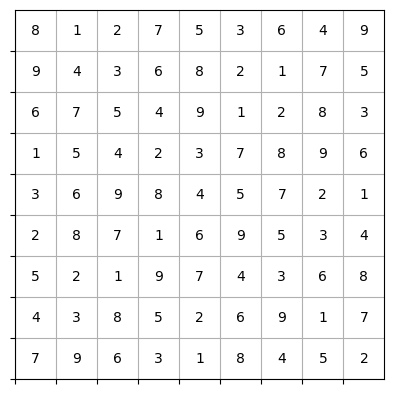

In [4]:
# Visualize solution
fig, ax = plt.subplots()

min_val, max_val, diff = 0, n, 1

N_points = (max_val - min_val) / diff
ind_array = np.arange(min_val, max_val, diff)

# This is used to visualize the Sudoku solution with the 16x16 grid below.
encode = {1: '1', 2: '2', 3: '3', 4: '4', 5: '5',
          6: '6', 7: '7', 8: '8', 9: '9', 10: 'A',
          11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G'}

xsol = prob.getSolution(assign)

for i1 in Q:
    for i2 in Q:
        for j1 in Q:
            for j2 in Q:
                c = encode[math.floor(1 + sum(xsol[i1*q + i2,j1*q + j2,k]*k for k in N) + 0.5)]
                ax.text (j1*q + j2, n - 1 - (i1*q + i2), c, va='center', ha='center')

ax.set_aspect('equal', 'box')
#set tick marks for grid
ax.set_xticks(np.arange(min_val-diff/2, max_val-diff/2))
ax.set_yticks(np.arange(min_val-diff/2, max_val-diff/2))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlim(min_val-diff/2, max_val-diff/2)
ax.set_ylim(min_val-diff/2, max_val-diff/2)
ax.grid()
plt.show()


## A variant with a $16\times 16$ grid

Below is a sudoku on a $16\times 16$ grid. Just run this cell and restart from the cell with the `import xpress` line.

In [5]:
grid4x4 = \
 [[ 0, 0,12, 0, 0, 2, 0, 0, 0, 7, 3, 0,13,15, 0, 0],
  [15, 0, 0, 0, 0, 3, 0, 0, 9, 0, 0, 0,12, 0, 0,10],
  [ 0, 0, 0, 0, 9, 0, 6, 0, 0, 0,12, 0, 0, 0, 2, 5],
  [ 6,11, 1, 0, 0,10, 5, 0, 0, 2, 0,15, 0, 0, 0, 0],
  [ 4, 6, 3, 0, 0, 0,13,14, 0, 0, 0, 0, 0, 7, 0, 0],
  [ 0,15,11, 0, 7, 0, 9, 0, 0, 0, 0, 0, 0, 0, 1, 0],
  [ 0, 1, 0,10,15, 0, 0, 0,11, 3,14, 0, 6, 0, 0, 0],
  [13, 0, 8, 7, 0, 5, 0, 0, 0, 1, 9,12, 0, 0, 0, 0],
  [ 0, 0, 0, 6, 3, 7,15, 4, 0, 0, 0, 0, 0,14, 0, 0],
  [ 0, 8, 0, 0, 0, 0, 0, 0, 0,11, 7, 0, 4, 0, 0, 0],
  [ 0, 0, 0, 0, 0, 0, 0, 0,13, 0, 0, 6, 9, 0, 3, 0],
  [ 0, 0, 0, 0, 2, 8,14, 0, 3, 0, 0,10, 0, 0,13, 7],
  [ 0, 0, 0, 8, 0, 0, 0, 7,10, 0, 0, 0, 0, 0, 5, 1],
  [ 0, 4,10, 1, 6, 0, 0, 0, 0,12, 0,14, 7, 3, 9,15],
  [ 3, 0,15, 0, 0, 0, 0, 8, 0, 0, 1, 0,14,12, 0, 0],
  [ 2, 0, 0, 9,12, 0, 0, 1, 0, 0, 0, 0, 0, 6, 8, 0]]

grid = grid4x4
q = 4